## Итоговый проект

###### Импорт необходимых библиотек 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import time
import datetime

### Подход 1: градиентный бустинг "в лоб"

###### 1. Загрузка датасета 

В рамках проекта предполагается решить следующую задачу: предсказать итог матча (выиграет команда _Radiant_ или _Dire_) по первым 5 минутам в игре Dota 2. Для решения дана выборка, извлеченная из сжатых текстовых файлов со строчками в формате JSON, где записаны сами матчи. Подробнее о датасете можно узнать на странице [kaggle-соревнования](https://www.kaggle.com/c/dota-2-win-probability-prediction/overview/description).

In [2]:
train_df = pd.read_csv('features.csv', index_col='match_id')
train_df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
print('\033[1m' + 'Список всех признаков в датасете:' + '\033[0m')
print([*train_df.columns])

Список всех признаков в датасете:
['start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items', 'r2_hero', 'r2_level', 'r2_xp', 'r2_gold', 'r2_lh', 'r2_kills', 'r2_deaths', 'r2_items', 'r3_hero', 'r3_level', 'r3_xp', 'r3_gold', 'r3_lh', 'r3_kills', 'r3_deaths', 'r3_items', 'r4_hero', 'r4_level', 'r4_xp', 'r4_gold', 'r4_lh', 'r4_kills', 'r4_deaths', 'r4_items', 'r5_hero', 'r5_level', 'r5_xp', 'r5_gold', 'r5_lh', 'r5_kills', 'r5_deaths', 'r5_items', 'd1_hero', 'd1_level', 'd1_xp', 'd1_gold', 'd1_lh', 'd1_kills', 'd1_deaths', 'd1_items', 'd2_hero', 'd2_level', 'd2_xp', 'd2_gold', 'd2_lh', 'd2_kills', 'd2_deaths', 'd2_items', 'd3_hero', 'd3_level', 'd3_xp', 'd3_gold', 'd3_lh', 'd3_kills', 'd3_deaths', 'd3_items', 'd4_hero', 'd4_level', 'd4_xp', 'd4_gold', 'd4_lh', 'd4_kills', 'd4_deaths', 'd4_items', 'd5_hero', 'd5_level', 'd5_xp', 'd5_gold', 'd5_lh', 'd5_kills', 'd5_deaths', 'd5_items', 'first_blood_time', 'first_blood_team', 'first_

Признаки были заранее выбраны из сырых данных составителями задания. Однако, не все из них нужны для последующего обучения, так как несут в себе скорее пагубное влияние. Имеются в виду последние 5 признаков (за исключнием целевого признака __radiant_win__), которые будут удалены, чтобы в последующем модель не переобучилась.

In [4]:
train_df = train_df.drop(['duration', 
                          'tower_status_radiant', 
                          'tower_status_dire',
                          'barracks_status_radiant',
                          'barracks_status_dire'], axis=1)
train_df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,1
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,0


Перейдем к анализу самих данных: для начала посмотрим, имеются ли пропуски.

###### 2. Наличие пропусков 

In [5]:
print(f'Всего строк в датасете: {len(train_df)}')

Всего строк в датасете: 97230


In [6]:
# сортировка столбцов так, чтобы оставались только столбцы с пропущенными значениями
na_values = pd.DataFrame(train_df.count(), columns=['count_of_values'])
na_values_present = na_values.where(na_values.iloc[:, 0] < len(train_df))
na_values_present = na_values_present.dropna().reset_index().rename(columns={'index': 'col_name'})
na_values_present

,col_name,count_of_values
0,first_blood_time,77677.0
1,first_blood_team,77677.0
2,first_blood_player1,77677.0
3,first_blood_player2,53243.0
4,radiant_bottle_time,81539.0
5,radiant_courier_time,96538.0
6,radiant_flying_courier_time,69751.0
7,radiant_first_ward_time,95394.0
8,dire_bottle_time,81087.0
9,dire_courier_time,96554.0


Данные пропуски можно объяснить следующим образом: в целом, пропуски значений обусловлены типом лобби, который является одним из признаков. Лобби могут быть как тренировочными или матчем 1vs1, так и полноценными турнирными. Потому, в некоторых лобби в принципе не могло быть такого события, как _first_blood_, происходящий только в случае первого убийства героя одной команды другой. 

Другие пропуски связаны с получением предмета одной или другой командой. То есть в некоторых боях могло случиться так, что команда попросту не приобретала данный предмет вовсе за весь матч, что может происходить по целому ряду причин, в том числе по причине самого типа лобби.

###### 3. Замена пропусков 

Пропуски можно заменить несколькими способами: 
- заменить их на 0, чтобы данные позиции у объектов не учитывались (в случае с линейными классификаторами); 
- заменить их на большие значения, которых нет в других объектах выборки (таким образом, данные позиции будут учитываться отдельно классификаторами типа случайного леса); 
- заменить их на среднее значение по признаку, либо же наиболее популярное значение, если это категориальный или порядковый признак.

Попробуем реализовать все три возможных варианта.

_Замена пропусков на 0_

In [7]:
list_of_cols_na = na_values_present.iloc[:, 0].to_numpy()
train_df_0 = train_df.copy()
for cols in list_of_cols_na:
    train_df_0[cols].fillna(0, inplace=True)
print('Осталось пропуски? -', train_df_0.isnull().values.any())

Осталось пропуски? - False


_Замена пропусков на большие значения_ 

In [8]:
train_df_large_values = train_df.copy()
for cols in list_of_cols_na:
    train_df_large_values[cols].fillna(999999999, inplace=True)
print('Остались пропуски? -', train_df_large_values.isnull().values.any())

Остались пропуски? - False


_Замена пропусков на среднее значение по признаку_

In [9]:
train_df_mean = train_df.copy()
for cols in list_of_cols_na:
    mean_value = np.mean(train_df_mean[cols])
    train_df_mean[cols].fillna(mean_value, inplace=True)
print('Остались пропуски? -', train_df_mean.isnull().values.any())

Остались пропуски? - False


Мы заменили пропуски различными способами и далее узнаем, какой метод оказался наиболее подходящим под ту или иную выбранную модель.

###### 4. Целевая переменная 

Нашей целевой переменной является последний столбец - _radiant_win_, который указывает на победу или поражение команды _radiant_. Также отдельно следует подготовить матрицу признаков.

In [10]:
y = train_df['radiant_win']

X_0 = train_df_0.drop(columns='radiant_win')
X_large_values = train_df_large_values.drop(columns='radiant_win')
X_mean = train_df_mean.drop(columns='radiant_win')

###### 5. Обучение модели градиентного бустинга 

В качестве первой модели будет использован градиентный бустинг. Оценку качества модели будем производить при помощи кросс-валидации на 5 фолдов с перемешиванием выборки, метрикой качества будет служить ROC-AUC или площадь под ROC-кривой.

In [11]:
cv = KFold(n_splits=5, shuffle=True)

classifier = GradientBoostingClassifier()

Посмотрим, каким образом все-таки влияет замена пропусков в датасете.

_Оценки качества при различных заменах пропусков_

__Внимание, следующий код работает крайне долго!__

In [12]:
start_time = datetime.datetime.now()

scores_with_0 = cross_val_score(classifier, X_0, y, scoring='roc_auc', cv=cv)
scores_with_large = cross_val_score(classifier, X_large_values, y, scoring='roc_auc', cv=cv)
scores_with_mean = cross_val_score(classifier, X_mean, y, scoring='roc_auc', cv=cv)

print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:16:12.192549


На графике представлено, каким образом распределились оценки качества при кросс-валидации при различных заменах пропусков.

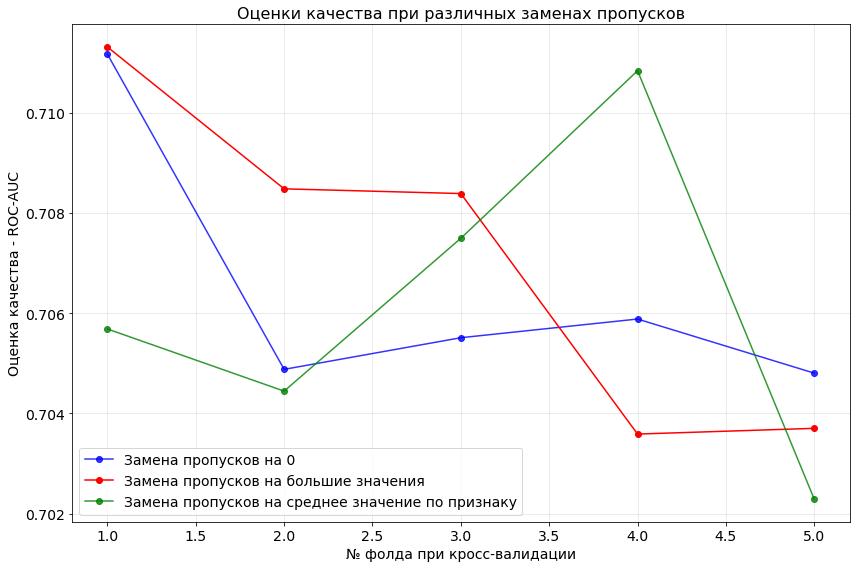

In [13]:
x = np.arange(1, 6, 1)
plt.figure(figsize=(12,8))
plt.plot(x, scores_with_0, marker='o',color='b', label='Замена пропусков на 0', alpha=0.8)
plt.plot(x, scores_with_large, marker='o', color='r', label='Замена пропусков на большие значения')
plt.plot(x, scores_with_mean, marker='o', color='g', alpha=0.8, label='Замена пропусков на среднее значение по признаку')
plt.xlabel('№ фолда при кросс-валидации', fontsize=14)
plt.ylabel('Оценка качества - ROC-AUC', fontsize=14)
plt.title('Оценки качества при различных заменах пропусков', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Как демонстрирует график, оценки качества хаотичным образом распределились между собой и имеются некоторые различия. Тем не менее, в целом оценка качества колеблется в одних и тех же пределах, что подтверждается далее средним значением по кросс-валидации:

In [14]:
print(f'Среднее значение ROC-AUC при замене пропусков на 0: {round(scores_with_0.mean(), 5)}')
print(f'Среднее значение ROC-AUC при замене пропусков на большое значение: {round(scores_with_large.mean(), 5)}')
print(f'Среднее значение ROC-AUC при замене пропусков на среднее значение по признаку: {round(scores_with_mean.mean(), 5)}')

Среднее значение ROC-AUC при замене пропусков на 0: 0.70645
Среднее значение ROC-AUC при замене пропусков на большое значение: 0.7071
Среднее значение ROC-AUC при замене пропусков на среднее значение по признаку: 0.70615


Заметно, что среднее качество практически идентично. Тем не менее, лучше заменять пропуски либо на 0, либо же на большое значение.

_Оценки качества при различном числе решающих деревьев_

Теперь можно перейти к оценке качества при помощи метрики ROC-AUC при различных значениях числа решающих деревьев у градиентного бустинга. Данные будем использовать с заменой пропусков на 0.

In [15]:
start_time = datetime.datetime.now()

cv = KFold(n_splits=5, shuffle=True)
n_trees = [10, 20, 30, 50, 100]
scores = []
for tree in n_trees:
    classifier = GradientBoostingClassifier(n_estimators=tree)
    score = cross_val_score(classifier, X_0, y, scoring='roc_auc', cv=cv)
    scores.append(score.mean())
    
print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:11:57.046354


Классификаторы обучались значительное время, что уже было выяснено ранее. Все это в том числе объясняется значительной выборкой и отсутствием какой-либо предобработки категориальных признаков. 

Посмотрим, какое максимальное итоговое качество и при каком числе деревьев показал градиентный бустинг. 

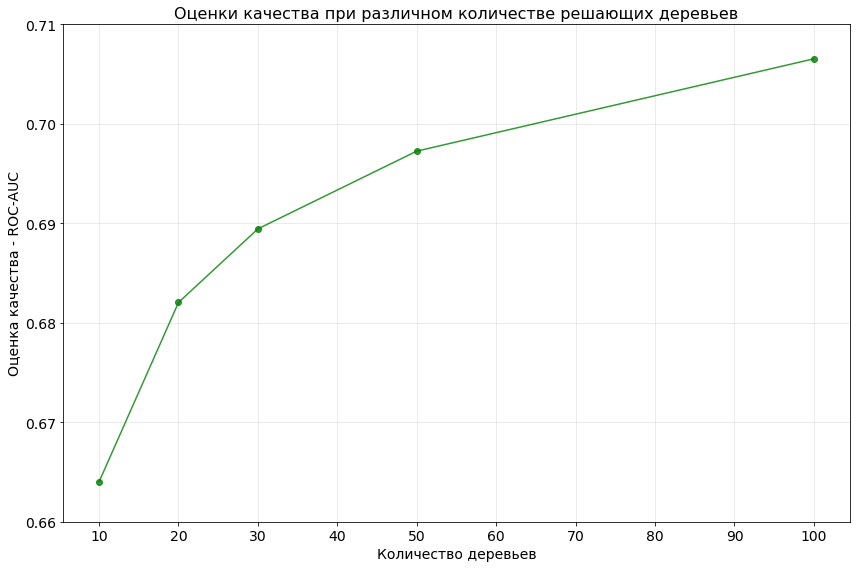

In [16]:
x = n_trees
plt.figure(figsize=(12,8))
plt.plot(x, scores, marker='o',color='g', alpha=0.8)
plt.xlabel('Количество деревьев', fontsize=14)
plt.ylabel('Оценка качества - ROC-AUC', fontsize=14)
plt.title('Оценки качества при различном количестве решающих деревьев', fontsize=16)
plt.xticks(np.arange(10, 110, 10), fontsize=14)
plt.yticks(np.arange(0.66, 0.72, 0.01), fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Можно заметить, что качество понемногу, но росло с увеличением количества деревьев, но больше всего росло на первых нескольких десятках. Более того, качество продолжит расти несколько меньшими темпами и далее, если еще увеличить количество деревьев в градиентном бустинге. 

###### Отчет по этапу

1. Пропуски имеют следующие признаки: _first_blood_time, first_blood_team, first_blood_player1, first_blood_player2, radiant_bottle_time, radiant_courier_time, radiant_flying_courier_time, radiant_first_ward_time, dire_bottle_time, dire_courier_time, dire_flying_courier_time, dire_first_ward_time._ В целом, пропуски значений обусловлены типом лобби, который является одним из признаков. Лобби могут быть как тренировочными или матчем 1vs1, так и полноценными турнирными. Потому, в некоторых лобби в принципе не могло быть такого события, как _first_blood_, происходящий только в случае первого убийства героя одной команды другой. Другие пропуски связаны с получением предмета одной или другой командой. То есть в некоторых боях могло случиться так, что команда попросту не приобретала данный предмет вовсе за весь матч, что может происходить по целому ряду причин, в том числе по причине самого типа лобби.


2. Целевой переменной является последний столбец - _radiant_win_, который указывает на победу или поражение команды _radiant_.


3. Общее время, которое было потрачено на обучение градиентного бустинга при значениях количества деревьев, равных 10, 20, 30, 50 и 100 заняло около 11 минут. Это достаточно большой промежуток времени, в то же время объясняется это, в том числе, размером самой выборки. Наилучшее качество, то есть площадь под ROC-кривой, показал градиентный бустинг со 100 деревьями - 0.706.


4. Можно использовать более, чем 30 деревьев в градиентном бустинге, однако это будет занимать больше времени на обучение. В данном случае, наиболее действенным вариантом будет уменьшить размер выборки, то есть случайным образом уменьшить выборку на, например, 25%.

### Подход 2: логистическая регрессия 

Воспользуемся алгоритмом логистической регрессии для ускорения времени на обучение и также для понимания работы линейных алгоритмов в данной задаче.

Для начала, для более корректной работы линейного алгоритма, отмасштабируем данные. Воспользуемся выборкой, где пропуски были заменены на 0.

In [17]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X_0)

Создадим новую модель с логистической регрессией и на кросс-валидации рассмотрим, при каком параметре регуляризации C модель покажет наилучший результат.

###### 1. Модель логистической регрессии с подбором С

In [18]:
start_time = datetime.datetime.now()

C = [0.1, 0.5, 1.0, 1.5, 2.0]
cv = KFold(n_splits=5, shuffle=True)
scores = []
for c in C:
    classifier = LogisticRegression(penalty='l2', C=c)
    score = cross_val_score(classifier, X_transformed, y, scoring='roc_auc', cv=cv)
    scores.append(score.mean())

print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:16.224037


Как видно из результатов по времени, логистической регрессии удалось гораздо быстрее обучиться на данных.

Рассмотрим, каким образом изменялось качество модели при различном параметре С.

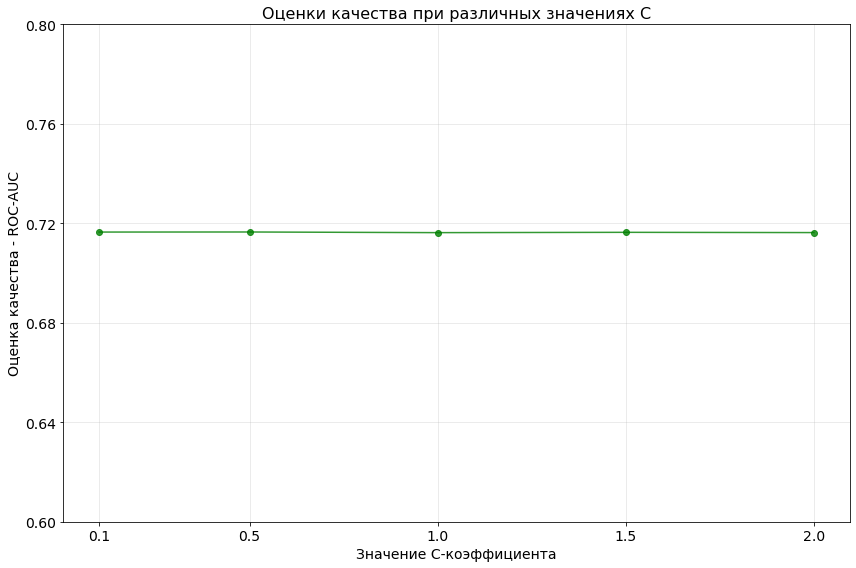

In [19]:
x = C
plt.figure(figsize=(12,8))
plt.plot(x, scores, marker='o',color='g', alpha=0.8)
plt.xlabel('Значение С-коэффициента', fontsize=14)
plt.ylabel('Оценка качества - ROC-AUC', fontsize=14)
plt.title('Оценки качества при различных значениях С', fontsize=16)
plt.xticks(C, fontsize=14)
plt.yticks(np.arange(0.6, 0.8, 0.04), fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
print(f'Оценка качества ROC-AUC логистической регрессии: {round(scores[0], 4)}')

Оценка качества ROC-AUC логистической регрессии: 0.7165


Как заметно из графика, модель никаким образом не меняется по качеству в зависимости от С. Это говорит о том, что существует какой-то ограничивающий фактор в данных, не позволяющий полноценно обобщить датасет моделью. Скорее всего, это связано с наличием категориальных признаков, что будет рассмотрено далее.

В то же время, среднее значение качества вне зависимости от значения С у логистической регрессии оказалось несколько лучше, чем у модели градиентного бустинга. Скорее всего, связано это с природой данных моделей: градиентный бустинг представляет собой композицию из решающих деревьев, которым достаточно тяжело работать не с категориальными признаками (с обычными числовыми); логистическая регрессия является одним из представителей линейных моделей, для которых работа с числовыми признаками наоборот более актуальна.

###### 2. Логистическая регрессия с датасетом без категориальных признаков 

Посмотрим, что изменится с качеством логистической регрессии, если удалить столбцы с категориальными признаками.

In [21]:
cat_features = ['lobby_type', 
                'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
                'd1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']

X_0_cat_removed = X_0.drop(columns=cat_features)
scaler_new = StandardScaler()
X_0_cat_removed = scaler_new.fit_transform(X_0_cat_removed)

In [22]:
start_time = datetime.datetime.now()

C = [0.1, 0.5, 1.0, 1.5, 2.0]
cv = KFold(n_splits=5, shuffle=True)
scores = []
for c in C:
    classifier = LogisticRegression(penalty='l2', C=c)
    score = cross_val_score(classifier, X_0_cat_removed, y, scoring='roc_auc', cv=cv)
    scores.append(score.mean())

print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:00:13.313512


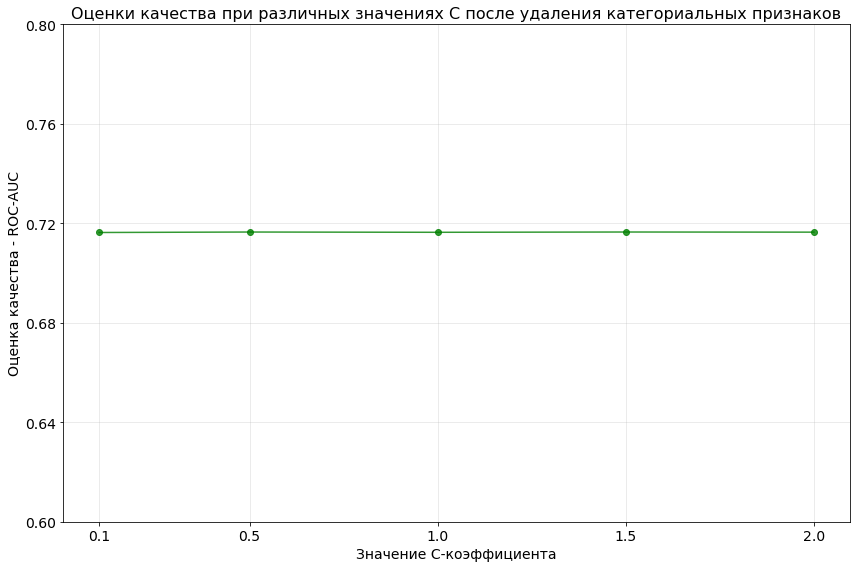

In [23]:
x = C
plt.figure(figsize=(12,8))
plt.plot(x, scores, marker='o',color='g', alpha=0.8)
plt.xlabel('Значение С-коэффициента', fontsize=14)
plt.ylabel('Оценка качества - ROC-AUC', fontsize=14)
plt.title('Оценки качества при различных значениях С после удаления категориальных признаков', fontsize=16)
plt.xticks(C, fontsize=14)
plt.yticks(np.arange(0.6, 0.8, 0.04), fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
print(f'Качество после удаления категориальных признаков: {round(scores[0], 4)}')

Качество после удаления категориальных признаков: 0.7163


Мы видим, что качество модели после удаления категориальных признаков ничуть не изменилось. То есть, можно предположить, что мы уперлись в своего рода бутылочное горлышко, с которым можно разобраться, если дополнительно видоизменить категориальные признаки.

###### 3. Количество уникальных значений некоторых категориальных признаков

Необходимо подробнее проанализировать категориальные признаки. А именно те, которые отвечают за героя, которым управляет тот или иной игрок.

На примере одного из таких признаков посмотрим, сколько всего возможных значений существует у данных категориальных признаков.

In [25]:
print(f'Количество уникальных значений в признаке: {len(X_0["r1_hero"].unique())}')
np.array(sorted(X_0['r1_hero'].unique()))

Количество уникальных значений в признаке: 108


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 109, 110, 112], dtype=int64)

###### 4. Использование подхода "мешок слов" для категориальных признаков 

Мы узнали, какие возможные значения могут принимать категориальные признаки, относящиеся к герою игрока. 

Учитывая, что максимальное значение признака 112, нам необходимо создать соответствующую матрицу размерности (_количество матчей_ x _112_) и для каждого матча указать: в соответствующем столбце, обозначающего номер героя, указать 1, если герой был выбран командой _Radiant_, -1, если герой был выбран командой _Dire_, в противном случае указать 0.

In [26]:
X_pick = np.zeros((X_0.shape[0], X_0["r1_hero"].unique().max()))

for i, match_id in enumerate(X_0.index):
    for p in range(5):
        X_pick[i, X_0.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_0.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

Присоединим полученную матрицу к основному датасету, где категориальные признаки удалены.

In [27]:
cat_features = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
                'd1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']

X_0_cat_removed = X_0.drop(columns=cat_features)
scaler_new = StandardScaler()
X_0_cat_removed = scaler_new.fit_transform(X_0_cat_removed)

In [28]:
X_new = np.hstack((X_0_cat_removed, X_pick))

###### 5. Обучение логистической регрессии на основе датасета с обработанными категориальными признаками

Еще раз рассмотрим оценку качества логистической регрессии, но теперь уже на основании данных с "мешком слов".

In [29]:
start_time = datetime.datetime.now()

C = [0.1, 0.5, 1.0, 1.5, 2.0]
cv = KFold(n_splits=5, shuffle=True)
scores = []
for c in C:
    classifier = LogisticRegression(penalty='l2', C=c, max_iter=200) # добавлен параметр max_iter для сходимости алгоритма
    score = cross_val_score(classifier, X_new, y, scoring='roc_auc', cv=cv)
    scores.append(score.mean())

print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:01:06.016037


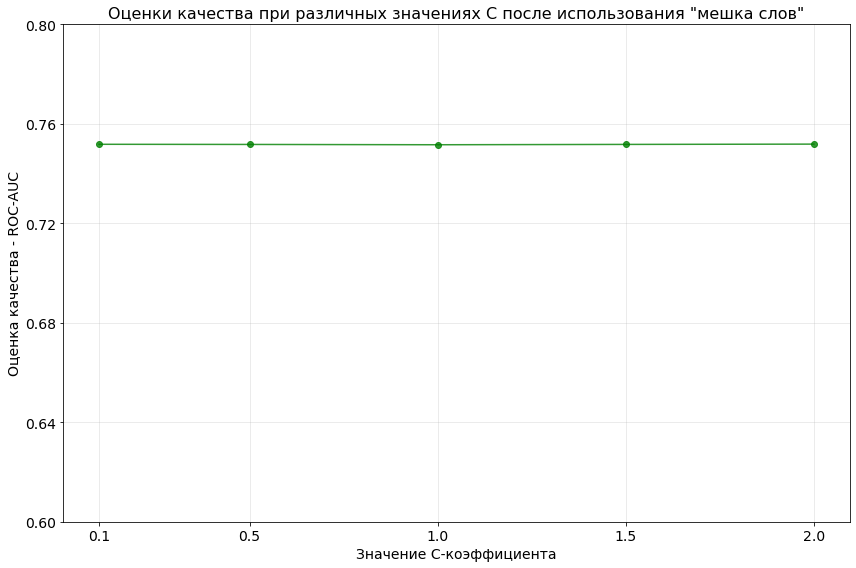

In [30]:
x = C
plt.figure(figsize=(12,8))
plt.plot(x, scores, marker='o',color='g', alpha=0.8)
plt.xlabel('Значение С-коэффициента', fontsize=14)
plt.ylabel('Оценка качества - ROC-AUC', fontsize=14)
plt.title('Оценки качества при различных значениях С после использования "мешка слов"', fontsize=16)
plt.xticks(C, fontsize=14)
plt.yticks(np.arange(0.6, 0.8, 0.04), fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Не смотря на то, что изменение параметра регуляризации не повлияло на качество, удалось добиться его увеличения. Это как раз таки по причине обработки категориальных признаков.

In [31]:
print(f'Итоговое качество модели логистической регрессии: {round(scores[0], 4)}')

Итоговое качество модели логистической регрессии: 0.7518


###### 6. Предсказания целевой переменной на тестовом датасете 

Теперь, когда имеется понимание наилучшей версии нашей модели, представляется возможным подсчитать итоговую целевую переменную для матчей, находящихся в тестовом датасете.

In [32]:
test_df = pd.read_csv('features_test.csv', index_col='match_id')
matches = test_df.index
test_df.sample(5)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
107199,1449791749,1,102,1,31,541,1,0,0,7,...,1,-14.0,133.0,-74.0,232.0,2,4,2,1,-33.0
100692,1449513970,1,1,3,1003,1711,27,0,0,5,...,0,-36.0,111.0,-84.0,NaN,3,4,1,0,-22.0
6246,1432937145,7,23,5,1992,1489,22,0,1,9,...,0,4.0,110.0,-83.0,NaN,0,4,2,0,-5.0
38290,1443196952,7,86,3,882,930,1,0,2,11,...,1,17.0,NaN,-84.0,189.0,6,4,3,1,-22.0
91871,1449136768,7,90,3,1115,1097,6,1,2,8,...,0,38.0,NaN,-83.0,NaN,2,2,2,0,-29.0


Предобработаем признаки по аналогии с обучающим датасетом.

In [33]:
test_df.fillna(0, inplace=True)

In [34]:
test_pick = np.zeros((test_df.shape[0], test_df["r1_hero"].unique().max()))

for i, match_id in enumerate(test_df.index):
    for p in range(5):
        test_pick[i, test_df.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        test_pick[i, test_df.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
cat_features = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
                'd1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero']

test_df = test_df.drop(columns=cat_features)

scaler = StandardScaler()
test_df = scaler.fit_transform(test_df)

X = np.hstack((test_df, test_pick))

Создадим нашу найденную наилучшую модель логистической регрессии и посмотрим, какие предсказания она выдаст тестовому датасету.

In [35]:
best_model = LogisticRegression(penalty='l2', max_iter=200)
best_model.fit(X_new, y)

LogisticRegression(max_iter=200)

In [36]:
predictions = best_model.predict_proba(X)
predictions

array([[0.17286284, 0.82713716],
       [0.24308029, 0.75691971],
       [0.81142295, 0.18857705],
       ...,
       [0.7639452 , 0.2360548 ],
       [0.36940595, 0.63059405],
       [0.57523674, 0.42476326]])

Мы видим, что получившиеся предсказания находятся на отрезке от 0 до 1 и представляют собой уверенность классификатора в том, что данный объект (матч) принадлежит либо классу 0, либо классу 1. И уже по получившимся предсказаниям видно, что в целом итоговый классификатор старается как можно точнее предсказывать принадлежность: это не простое гадание 0.5 на 0.5. 

Итоговые вероятности принадлежности к 1 классу (победа команды Radiant):

In [37]:
radiant_win = predictions[:, 1]

radiant_win = np.expand_dims(radiant_win, axis=1)
matches = np.expand_dims(matches, axis=1)

predictions_radiant = pd.DataFrame(np.hstack((matches, radiant_win)), columns=['match_id', 'radiant_win'])
predictions_radiant.head()

,match_id,radiant_win
0,6.0,0.827137
1,7.0,0.756920
2,10.0,0.188577
3,13.0,0.860368
4,16.0,0.239159


In [38]:
print(f'Наименьшее значение предсказания победы radiant - {round(predictions_radiant["radiant_win"].min(), 4)}')
print(f'Наибольшее значение предсказания победы radiant - {round(predictions_radiant["radiant_win"].max(), 4)}')

Наименьшее значение предсказания победы radiant - 0.0086
Наибольшее значение предсказания победы radiant - 0.9965


###### Отчет по этапу

1. Среднее значение качества вне зависимости от значения С у стандартной логистической регрессии оказалось на уровне в около 0.716, что больше, чем у модели градиентного бустинга. Более того, логистическая регрессия справилась с обучением значительно быстрее градиентного бустинга. Скорее всего, связано это с природой данных моделей: градиентный бустинг представляет собой композицию из решающих деревьев, которым достаточно тяжело работать не с категориальными признаками (с обычными числовыми); логистическая регрессия является одним из представителей линейных моделей, для которых работа с числовыми признаками наоборот более актуальна.
2. Качество логистической регрессии после удаления категориальных признаков ничуть не изменилось - около 0.716. То есть, можно предположить, что мы уперлись в своего рода бутылочное горлышко. То есть как раз необработанные категориальные признаки не влияли на качество, но если их преобразовать, то качество модели может увеличиться.
3. Всего существует 108 уникальных значений героев, однако максимальное значение героя находится на отметке в 112.
4. После использования "мешка слов" качество модели улучшилось - стало равным около 0.75. Это как раз таки по причине того, что категориальные признаки были соответствующим образом преобразованы при помощи "мешка слов".
5. Наименьшее значение предсказания того, что победу в матче одержит команда _Radiant_ оказалось равным меньше 0.01. В то же время, наибольшее значение такого предсказания получилось равным практически 1, или 0.99.